# Hierachical Clustering

<span>Hierarchical Clustering methods are a group of clustering algorithms that clustering data points into larger clusters based on a similarity metric. There are two groups of hierarchical clustering methods that approach this problem in different manners. Agglomerative clustering would be the "bottom up" approach and divisive clustering would be a "top-down approach". I will be going through an agglomerative clustering problem for the remainder of this notebook.</span>

**Dataset**

2014 FiFA World Cup Dataset: https://www.kaggle.com/abecklas/fifa-world-cup

### Import Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd 
import sklearn
import seaborn as sns
import warnings

from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from sqlalchemy import create_engine
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (9.0, 3.0)

# Set warning options
warnings.filterwarnings('ignore');

## Agglomerative Clustering

<span>Agglomerative Clustering is a clustering method that works under the assumption that each point in the datasets is a cluster and that some groups are more similar to others. Therefore you can work your ways upwards from each group and begin merging smaller clusters with each other into larger ones.  As you work your way up, the cluster's will start converging based on their similarities. 

Agglomerative clustering falls under the category of a hierarchical clustering method and is the opposite approach to Divisive clustering. While both are similar hierarchical clustering methods, Agglomerative Clustering is the "bottom-up" approach while Divisive Clustering would be the "top-down" approach. </span>

### Import Data

I use a dataset that is open-source and available on Kaggle called "FIFA World Cup." This dataset records the outcome of every FIFA match in the 2014 FIFA World Cup. We use an agglomerative cluster algorithm to investigate the inherit segment of matches in the World Cup.

In [2]:
# Set your local database parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'fifa_world_cup'

# Create a MySQLEngine
engine = create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

# Import data from SQL
df = pd.read_sql("""
                SELECT `Year`,`Stage`,`Home Team Initials`, 
                `Away Team Initials`, `Home Team Goals`, `Away Team Goals`, 
                `Half-time Home Goals`, `Half-time Away Goals` FROM Matches
                WHERE Year = 2014;
                 """, engine).dropna(how='any', axis=0)
# Some preprocessing on the data
df['Year'] = df['Year'].astype(int).astype(str)
df['Index'] = df['Home Team Initials'] +' vs '+ df['Away Team Initials'] +' - '+ df['Stage'] +' - ' + df['Year']
df = df.set_index(['Index'])
df = df.drop(['Year', 'Stage', 'Home Team Initials','Away Team Initials'], axis =1)
df = df.drop_duplicates(keep='first')

# Subsample our data down to 100 games
print(f'dataframe shape: {df.shape}')
df.head()


dataframe shape: (32, 4)


,Home Team Goals,Away Team Goals,Half-time Home Goals,Half-time Away Goals
Index,,,,
BRA vs CRO - Group A - 2014,3,1,1,1
MEX vs CMR - Group A - 2014,1,0,0,0
ESP vs NED - Group B - 2014,1,5,1,1
CHI vs AUS - Group B - 2014,3,1,2,1
COL vs GRE - Group C - 2014,3,0,1,0


### Scipy Implementation

We will first use the Scipy package to plot a dendrogram. This dendrogram gives an excellent visual representation of methodology behind hierarchical clustering model. The plot also makes it easy to view the distance between clusters and view the similarities between groups.

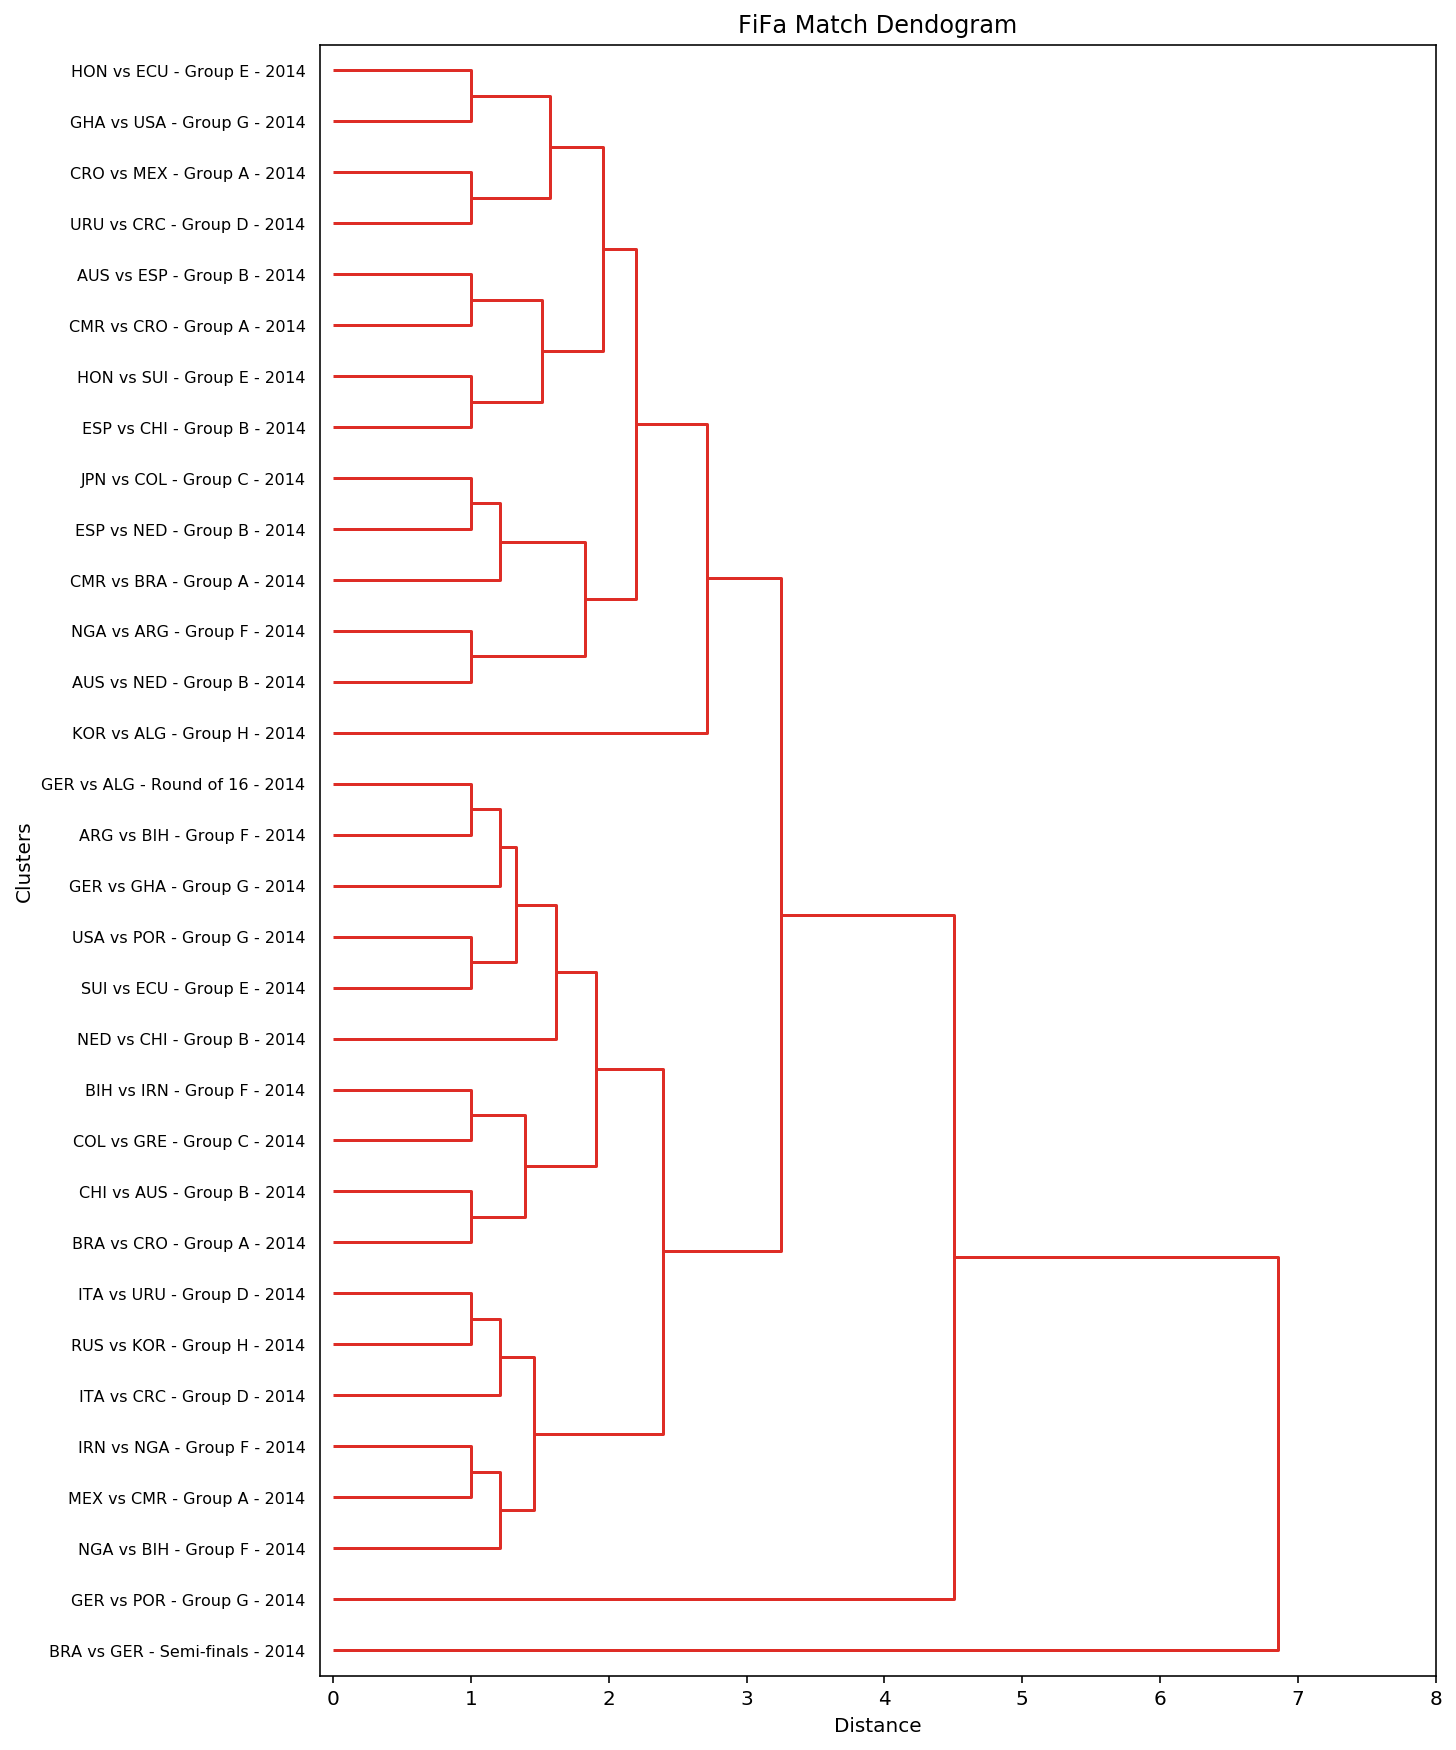

In [3]:
# Dataframme to np.array
X = df.values

# Creaet the linkage map of the dendogram
linkagemat = linkage(X, 'average')

# Set the color of the dendogram
set_link_color_palette(['#de2d26'])

# Plot dendogram
plt.figure(figsize=(10, 15))
dendrogram(
    linkagemat,
    p = 0,
    truncate_mode = None,
    orientation='right',
    labels =list(df.index.values),
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=8,  # font size for the x axis labels
    color_threshold = 8
);
plt.title('FiFa Match Dendogram')
plt.xlabel('Distance')
plt.ylabel('Clusters')
plt.xlim(-0.1,8);

### Sklearn Implementation

Sklearn's implementation of the agglomerative clustering is a bit more feature rich. It outputs an array clustering assignment instead of dendrograms, and we can use that data to conduct some exploratory analysis about our clusters. Sklearn also allows us to perform agglomerative clustering to a given number of clusters. We will use this feature to cluster our data into four groups.

In [4]:
# Fit the model
agglom = AgglomerativeClustering(n_clusters=4)
agglom.fit(X);

# Number of Leaves in the cluster
print(f'Number of leave in our tree: {agglom.n_leaves_}')

#View training predictions
clusters = agglom.fit_predict(X)
print(f'Clusters Assignments: {clusters}')

Number of leave in our tree: 32
Clusters Assignments: [3 1 0 3 3 0 1 1 3 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 3 0 1 2]


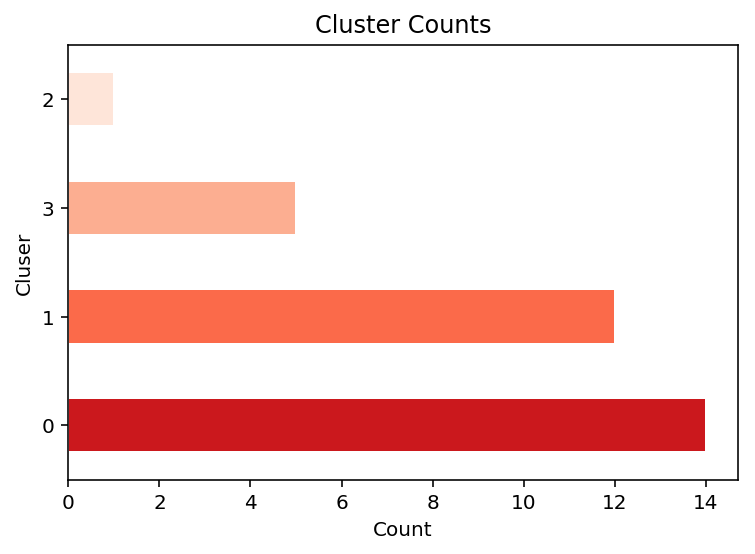

In [5]:
# Plot Cluster Counts 
pred_clusters = agglom.fit_predict(X)
target_counts = pd.Series(pred_clusters).value_counts()
target_counts.plot.barh(colors=['#cb181d', '#fb6a4a', '#fcae91', '#fee5d9'], 
                        edgecolor='white');
plt.title('Cluster Counts')
plt.xlabel('Count')
plt.ylabel('Cluser');

### Cluster Segmentation

We can do a simple groupby on our data after appending the cluster information to view the characteristic of our clusters. As we are dealing with dimension space greater than 2, it can be a bit harder to interpret the characteristics of our clusters at first glance. 

In [6]:
# Import data from SQL
segments = pd.read_sql("""
                SELECT * FROM Matches WHERE Year = 2014;
                 """, engine).dropna(how='any', axis=0)
# Some preprocessing on the data
segments['Year'] = segments['Year'].astype(int).astype(str)
segments['Index'] = segments['Home Team Initials'] +' vs '+ segments['Away Team Initials'] +' - '+ segments['Stage'] +' - ' + segments['Year']
segments = segments.set_index(['Index'])
segments = segments.drop(['Year', 'Stage', 'Home Team Initials','Away Team Initials'], axis =1)
segments = segments.drop_duplicates(subset=['Home Team Goals', 'Away Team Goals', 'Half-time Home Goals',
       'Half-time Away Goals'], keep='first')

# Appending Cluster information
segments['cluster'] = clusters

# View cluster characteristic
summary = segments.select_dtypes(include=['float','int']).groupby('cluster').mean()
summary = summary.drop(['RoundID', 'MatchID','Attendance'], axis=1)
summary

,Home Team Goals,Away Team Goals,Half-time Home Goals,Half-time Away Goals
cluster,,,,
0,0.929,3.214,0.500,1.286
1,1.167,1.333,0.167,0.667
2,2.000,1.000,0.000,0.000
3,3.200,0.600,1.600,0.400


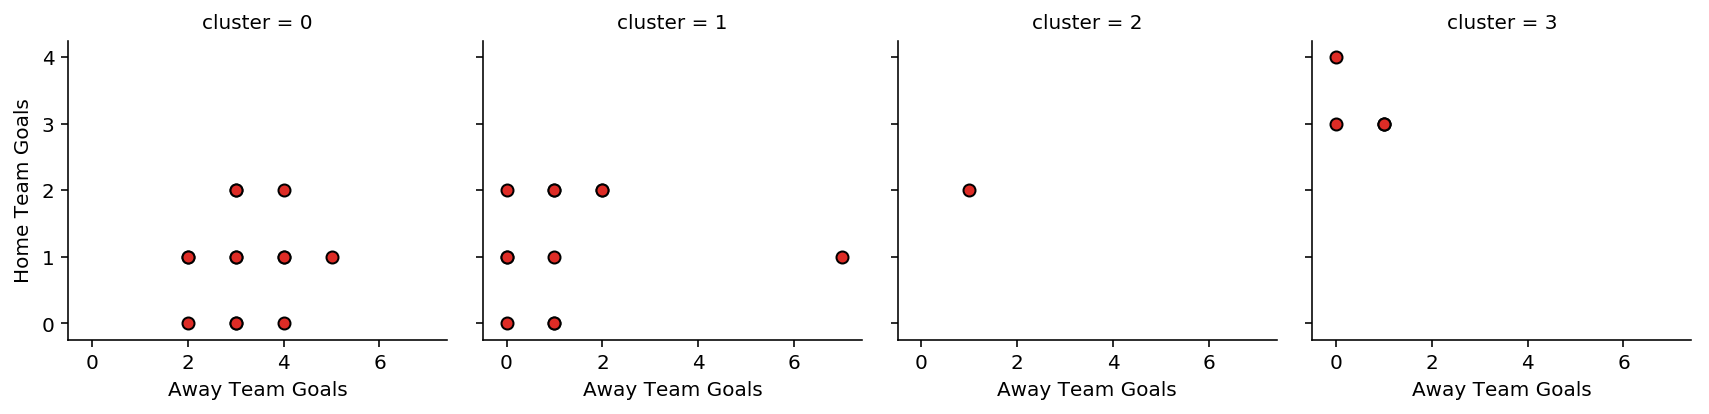

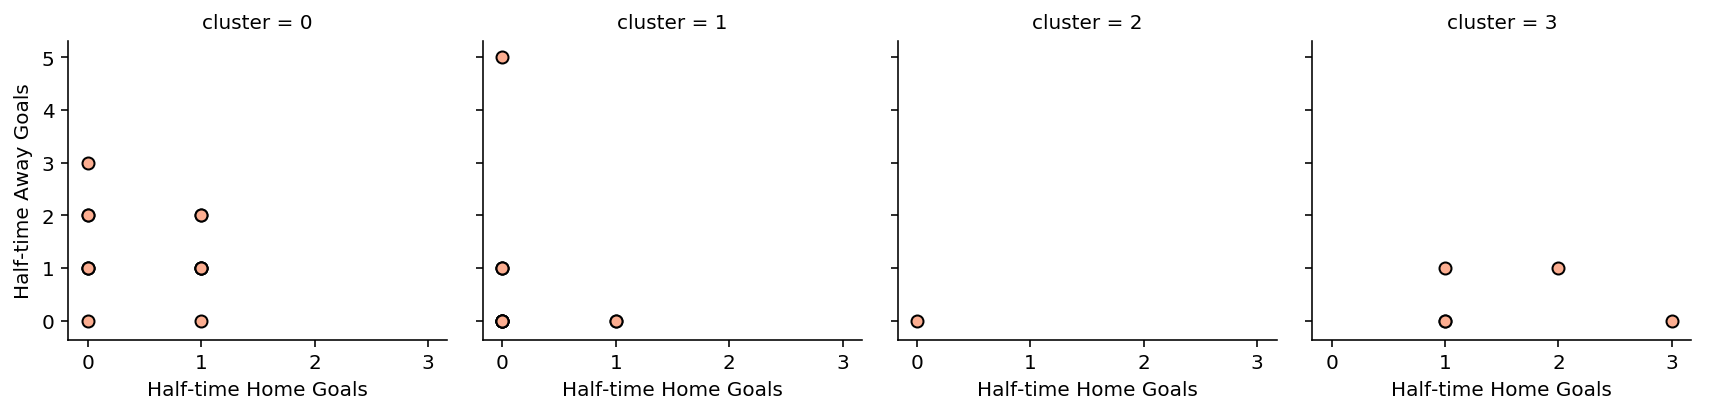

In [7]:
# Plot a Facet Grid to view cluster characteristics
fcplot = sns.FacetGrid(segments, col='cluster')
fcplot = (fcplot.map(plt.scatter, "Away Team Goals", "Home Team Goals", color='#DE2C26', 
           edgecolor='black'))

fcplot = sns.FacetGrid(segments, col='cluster')
fcplot = (fcplot.map(plt.scatter, "Half-time Home Goals", "Half-time Away Goals", color='#FCAE91', 
           edgecolor='black'))

By plotting the scatterplot of each cluster group and its feature, you can start to make out the characteristics of each cluster. I have listed them below.

- Cluster 0: Games where few goals scored by half-time, but where many goals were scored after half-time
- Cluster 1: Games where few goals scored by half-time, and few goals were scored after half-time
- Cluster 2: Games where no goals were scored by half-time, and few were scored before
- Cluster 3: Games where many goals were scored before half-time, and a few goals after half-time

###  Linkage Options

At the same time, we could have explored more linkage or distance measurements for our clustering. In the above example, I use "ward" linkage and "Euclidean" distance. These hyperparameters are the defaults for Sklearn. Below, I have modified the linkage and distance metric hyperparameters to view the effects the hyperparameters have on the overall our clusters.

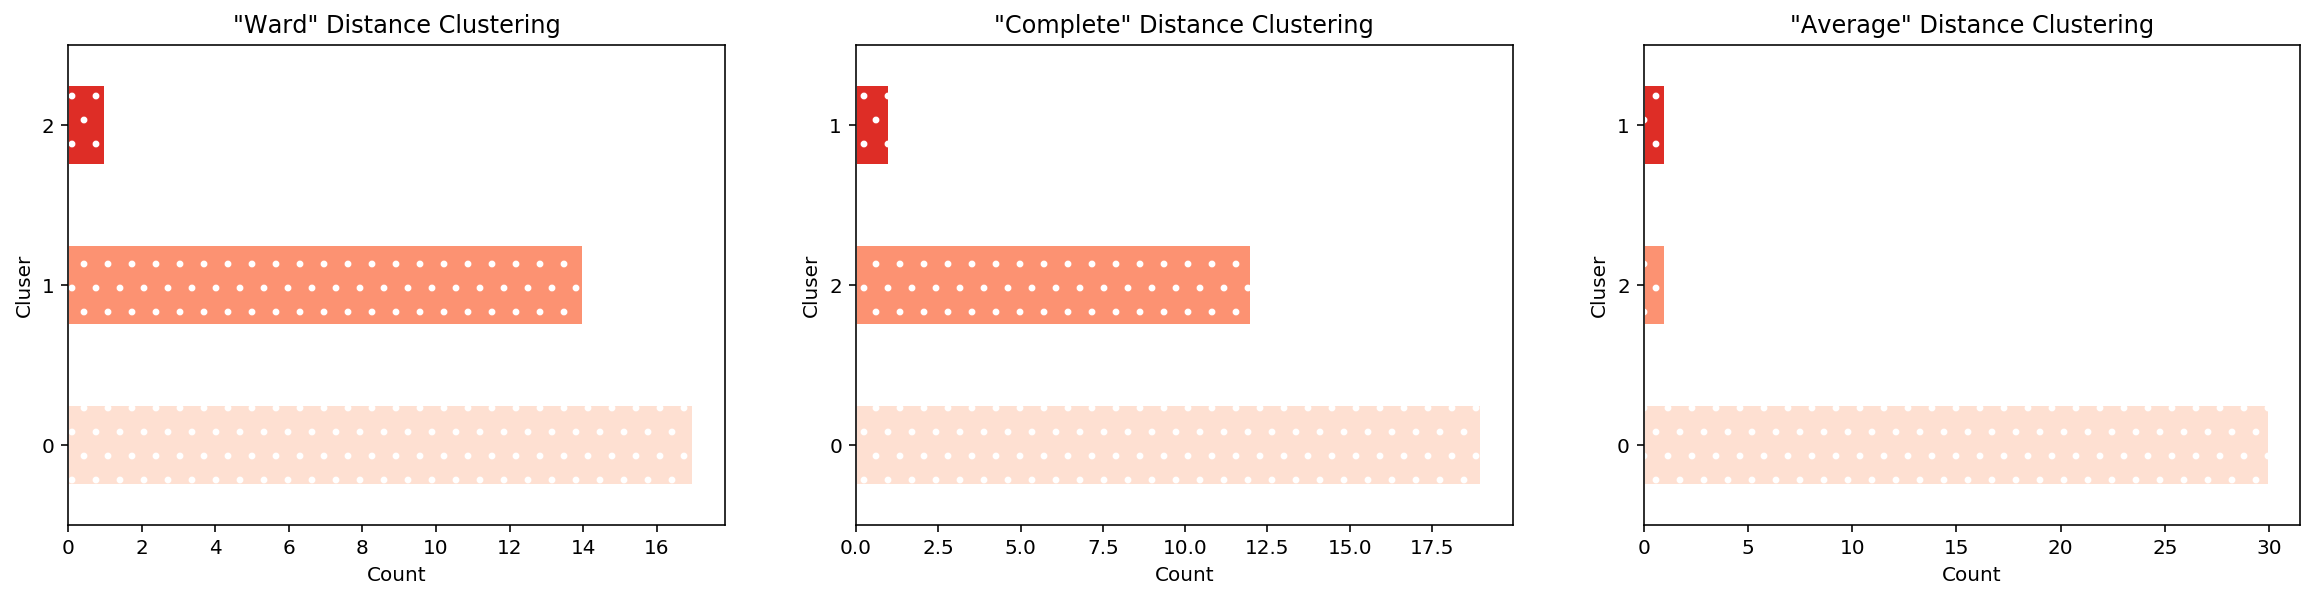

In [8]:
# Define paraameter range and score lists
linkage_range = ['ward', 'complete', 'average']

# Set up grid
mpl.rcParams['figure.figsize'] = (20.0, 15.0)
plt.figure()
fig = gridspec.GridSpec(3, 3)
grid_length = list(range(1, 3))
tuple_grid = [(i, j) for i in grid_length for j in grid_length]


# Train a knn_model for every neighbour value in our list
for j,i in enumerate(linkage_range):
    plt.subplot2grid((3, 3), (0, j))
    agglom = AgglomerativeClustering(n_clusters=3, linkage=i)
    pred_train_y = agglom.fit_predict(X)
    
    target_counts = pd.Series(pred_train_y).value_counts()
    target_counts.plot.barh(colors=['#fee0d2','#fc9272','#de2d26'], 
                            edgecolor='white',hatch='.');
    plt.title('"'+str.title(i)+'" Distance Clustering')
    plt.xlabel('Count')
    plt.ylabel('Cluser');

### General Notes

- Sklearn's implementation uses 2 clusters and Euclidean distance by default
- Other distance metrics can be used such as “Euclidean”, “l1”, “l2”, “Manhattan”, “cosine”, or ‘precomputed’ distance measurements.
    - Ward linkage only accepts Euclidean distance
- Linkage refers to the methodology we use to aggregate the distance metrics in each cluster before comparing that measurement with other clusters. So before we compare Cluster A with Cluster B, what metric should we be aggregating between all the points within Cluster A
    - Ward: Minimizes the variance of the clusters
    - Average: Uses the average of all distances of each observation of the two sets
    - Complete/Maximum: Uses the maximum distance between all observations of the twos set
- In large datasets, memory can start to become an issue when determining the linkage.
- Sklearn has a memory parameter to cache the tree after computation to a subdirectory using Joblib

### Sources

- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html
- https://en.wikipedia.org/wiki/Hierarchical_clustering
- https://seaborn.pydata.org/generated/seaborn.clustermap.html
- https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

Author: Kavi Sekhon